<a href="https://colab.research.google.com/github/Nell87/drivendata_richter/blob/main/script/02_feature_selection_and_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing data** 

In [17]:
####    INCLUDES  _______________________________________ #### 
#Loading Libraries:# 
import pandas as pd
import os
import numpy as np
import time   #  provides many ways of representing time in code

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

####    READING TRAIN AND TEST DATA _______________________________________ #### 
train_values= data = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/train_values.csv",index_col='building_id')
train_labels = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/train_labels.csv",index_col='building_id')
train_merge = train_values.merge(train_labels, on = 'building_id', how = 'inner',)
test = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/test_values.csv",index_col='building_id')
print(train_merge.shape)

(260601, 39)


In [18]:
# Add labels
damage_map = {1:"Low", 2:"Medium", 3:"High"}
train_merge["damage_grade"] = train_merge["damage_grade"].map(damage_map)

# **Feature engineering** 

## **Feature engineering: Location features**
The features **geo_level_1_id, geo_level_2_id, geo_level_3_id** represent the geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

For every location feature there is a high number of categorical values, so we'll apply feature engineering on them. We'll replace every value with their conditional probabilities respect to every damage_grade category

In [19]:
# Function to replace a categorical feature with many values, with their conditional probabilities respecto to the predicted feature
def categoricalvalues_condprob(data, index, pred_feature, new_column_name):
  # Create prob table
  probs = data.groupby(index).size().div(len(data))
  probs_group = data.groupby([index, pred_feature]).size().div(len(data)).div(probs, axis=0, level=index).reset_index()
  probs_group.columns= [index, pred_feature, new_column_name]
  probs_group_wide = probs_group.pivot(index=[index], columns = pred_feature,values = new_column_name) #Reshape from long to wide
  probs_group_wide = probs_group_wide.reset_index()
  
 # Rename columns
  unique_values = np.unique(data[pred_feature])
  unique_values = -(len(unique_values))
  for i in range(unique_values,0):
    probs_group_wide.rename(columns={probs_group_wide.columns[i]: index + "_" + str(probs_group_wide.columns[i])}, inplace = True)
    
  # Add column to main dataset
  data_merge = data.merge(probs_group_wide, on=index, how='left')

  # Return dataset
  return data_merge

# Apply the function
train_merge_prep = categoricalvalues_condprob(train_merge, 'geo_level_1_id', 'damage_grade', 'prob_cond_geo_level_1')
train_merge_prep = categoricalvalues_condprob(train_merge_prep, 'geo_level_2_id', 'damage_grade', 'prob_cond_geo_level_2')
train_merge_prep = categoricalvalues_condprob(train_merge_prep, 'geo_level_3_id', 'damage_grade', 'prob_cond_geo_level_3')

# Get rid of the original categorical features
train_merge_prep = train_merge_prep.drop('geo_level_1_id', axis=1)
train_merge_prep = train_merge_prep.drop('geo_level_2_id', axis=1)
train_merge_prep = train_merge_prep.drop('geo_level_3_id', axis=1)

train_merge_prep.fillna({"geo_level_1_id_Low":0, "geo_level_1_id_Medium":0, "geo_level_1_id_High":0,
                         "geo_level_2_id_Low":0, "geo_level_2_id_Medium":0, "geo_level_2_id_High":0,
                         "geo_level_3_id_Low":0, "geo_level_3_id_Medium":0, "geo_level_3_id_High":0}, inplace=True)

train_merge_prep

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,damage_grade,geo_level_1_id_High,geo_level_1_id_Low,geo_level_1_id_Medium,geo_level_2_id_High,geo_level_2_id_Low,geo_level_2_id_Medium,geo_level_3_id_High,geo_level_3_id_Low,geo_level_3_id_Medium
0,2,30,6,5,t,r,n,f,q,t,...,High,0.248185,0.086461,0.665354,0.744444,0.003704,0.251852,0.837838,0.000000,0.162162
1,2,10,8,7,o,r,n,x,q,s,...,Medium,0.519549,0.034277,0.446174,0.497487,0.010050,0.492462,0.125000,0.062500,0.812500
2,2,10,5,5,t,r,n,f,x,t,...,High,0.584996,0.021627,0.393378,0.601136,0.082386,0.316477,0.610294,0.029412,0.360294
3,2,10,6,5,t,r,n,f,x,s,...,Medium,0.130678,0.129718,0.739603,0.126829,0.019512,0.853659,0.129032,0.032258,0.838710
4,3,30,8,9,t,r,n,f,x,s,...,High,0.384672,0.046959,0.568370,0.378613,0.029865,0.591522,0.377049,0.008197,0.614754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,1,55,6,3,n,r,n,f,j,s,...,Medium,0.137269,0.083215,0.779516,0.103448,0.172414,0.724138,0.071429,0.000000,0.928571
260597,2,0,6,5,t,r,n,f,q,s,...,High,0.807546,0.013066,0.179388,0.934866,0.003831,0.061303,0.979592,0.000000,0.020408
260598,3,55,6,7,t,r,q,f,q,s,...,High,0.807546,0.013066,0.179388,0.918919,0.024024,0.057057,0.863636,0.045455,0.090909
260599,2,10,14,6,t,r,x,v,s,j,...,Medium,0.085872,0.354986,0.559142,0.039624,0.507429,0.452947,0.012712,0.220339,0.766949


# **Feature selection** 

## **Feature selection: Random Forest Feature Importance**

<ipython-input-20-e8045d6441b6>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_merge_prep = pd.get_dummies(train_merge_prep.drop("damage_grade",1), drop_first = True)
<ipython-input-20-e8045d6441b6>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_1 = rf_clf_1.fit(x_train, y_train)


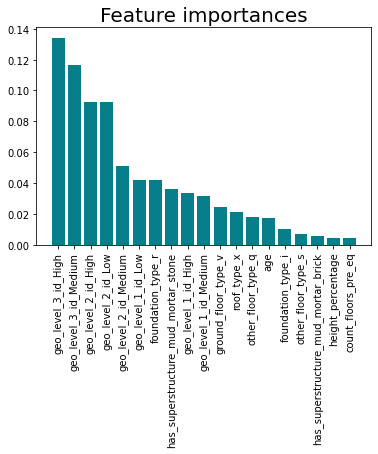

In [20]:
# Dummify
train_merge_prep = pd.get_dummies(train_merge_prep.drop("damage_grade",1), drop_first = True)

# Oversampling
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_resample(train_merge_prep,train_labels)

# Split in train/test
x_train, x_test, y_train, y_test = train_test_split(os_features, os_labels, test_size = 0.2, random_state = 42)

rf_clf_1 = RandomForestClassifier(random_state=314, n_estimators = 100,
                                  max_features = 'auto', max_depth = 10,
                                  min_samples_leaf = 20)

start_time = time.time()
rf_clf_1 = rf_clf_1.fit(x_train, y_train)  
rf_clf_1_time_fit = time.time() - start_time   

# Check the importance
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': rf_clf_1.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances[1:20]

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

## **Feature selection: Chi-Squared between Categorical features**

## **Feature selection: Correlation between numerical features**


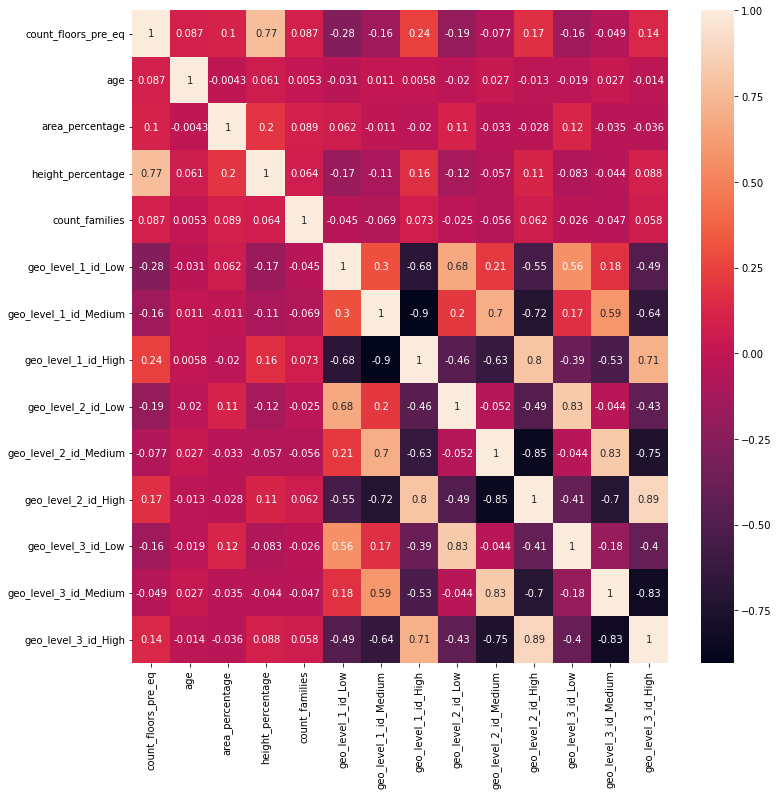

In [21]:
corr_matrix=train_merge_prep[["count_floors_pre_eq","age", "area_percentage", "height_percentage", "count_families",
                         "geo_level_1_id_Low", "geo_level_1_id_Medium", "geo_level_1_id_High",
                         "geo_level_2_id_Low", "geo_level_2_id_Medium", "geo_level_2_id_High",
                         "geo_level_3_id_Low", "geo_level_3_id_Medium", "geo_level_3_id_High"]].corr()
plt.figure(figsize=(12, 12))                       
sns.heatmap(corr_matrix, annot=True)
plt.show()